In [1]:
!pip3 install pyro-ppl
!pip3 install arviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 4.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import arviz as az

#pyro.set_rng_seed(98728292)

In [41]:
def g(x):
    return -torch.sin(6*np.pi*x)**2 + 6*x**2 - 5*x**4 + 3/2

def gen_data():
    l = 30
    x = (torch.arange(1, l+1)-1)/(l-1)
    y = g(x) + np.sqrt(0.01) * torch.randn(len(x))
    permutation = torch.randperm(len(x))
    x_shuffle = x[permutation]
    y_shuffle = y[permutation]
    x_train = x_shuffle[:20]
    y_train = y_shuffle[:20]
    x_eval = x_shuffle[20:]
    y_eval = y_shuffle[20:]
    return x_train, y_train, x_eval, y_eval

def log_likelihood(x, y, params):
    rbf = gp.kernels.RBF(input_dim=1, variance=params[1], lengthscale=params[0])
    periodic = gp.kernels.Periodic(input_dim=1, period=params[3], lengthscale=params[2], variance=params[4])
    kernel = gp.kernels.Sum(kern0=rbf, kern1=periodic)
    noise_y = params[5]
    n = len(y)
    K = kernel.forward(x)
    like1 = -1/2 * y @ torch.linalg.inv(noise_y * torch.eye(n) + K) @ y
    like2 = -1/2 * torch.log(torch.linalg.det(noise_y * torch.eye(n) + K))
    like3 = -n/2 * torch.log(2*torch.tensor(np.pi))
    return like1 + like2 + like3

def approximate_log_likelihood(x, y, posterior_samples):
    log_likelihoods = []
    for rbf_l, rbf_v, per_l, per_p, per_v, noise in zip(posterior_samples['kernel.kern0.lengthscale'], posterior_samples['kernel.kern0.variance'],
                                                        posterior_samples['kernel.kern1.lengthscale'], posterior_samples['kernel.kern1.period'],
                                                        posterior_samples['kernel.kern1.variance'], posterior_samples['noise']):
        # print(rbf_l, rbf_v, per_l, per_p, per_v, noise)
        log_likelihoods.append(log_likelihood(x, y, [rbf_l, rbf_v, per_l, per_p, per_v, noise]))
    return torch.tensor(log_likelihoods).mean()

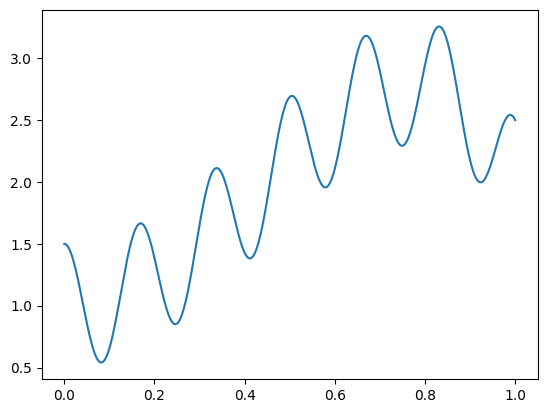

In [4]:
# Plot of data generating function
xs = torch.linspace(0, 1.0, 500)
ys = g(xs)
plt.plot(xs, ys)

In [29]:
x_train, y_train, x_test, y_test = gen_data()

# Defining our kernels and GP-model
rbf = gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(0.9))
periodic = gp.kernels.Periodic(input_dim=1, period=torch.tensor(0.5), lengthscale=torch.tensor(1.0), variance=torch.tensor(1.0))
kernel = gp.kernels.Sum(kern0=rbf, kern1=periodic)
gpr = gp.models.GPRegression(x_train, y_train, kernel=kernel, noise=torch.tensor(0.01))

# Putting priors on our kernel parameters
gpr.kernel.kern0.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
gpr.kernel.kern1.period = pyro.nn.PyroSample(dist.Exponential(4.0))
gpr.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
gpr.kernel.kern1.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
gpr.noise = pyro.nn.PyroSample(dist.Gamma(1.0, 1.0))

In [33]:
nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile=True)
mcmc=pyro.infer.MCMC(nuts_kernel, num_samples=500, num_chains=2, warmup_steps=1000)
mcmc.run()

/usr/local/lib/python3.10/dist-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Warmup:   0%|          | 0/1500 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/15

/usr/local/lib/python3.10/dist-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


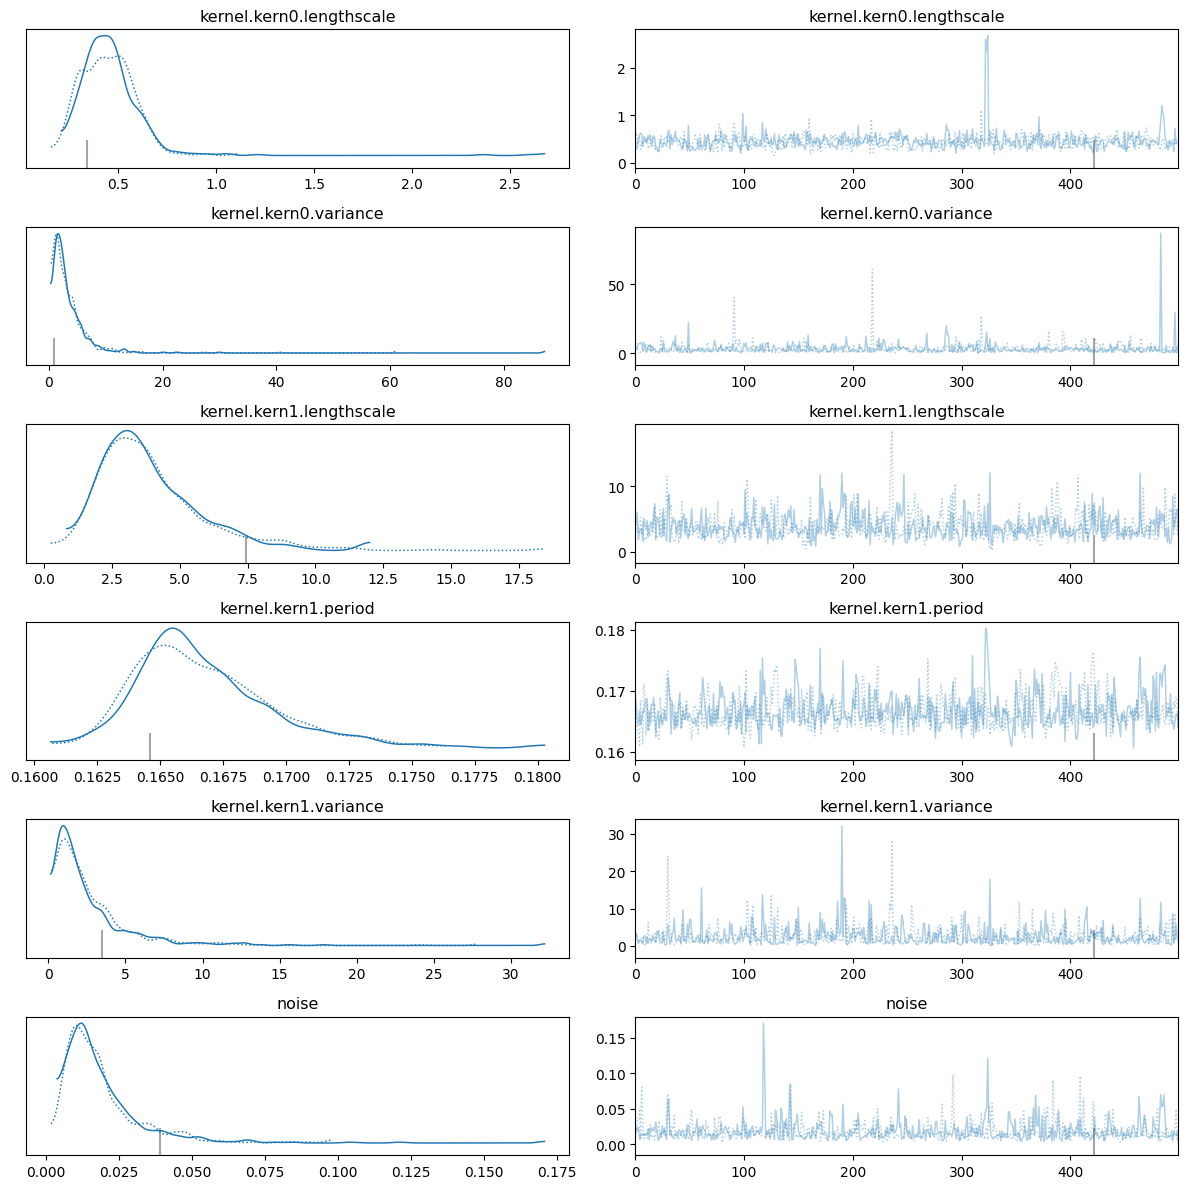

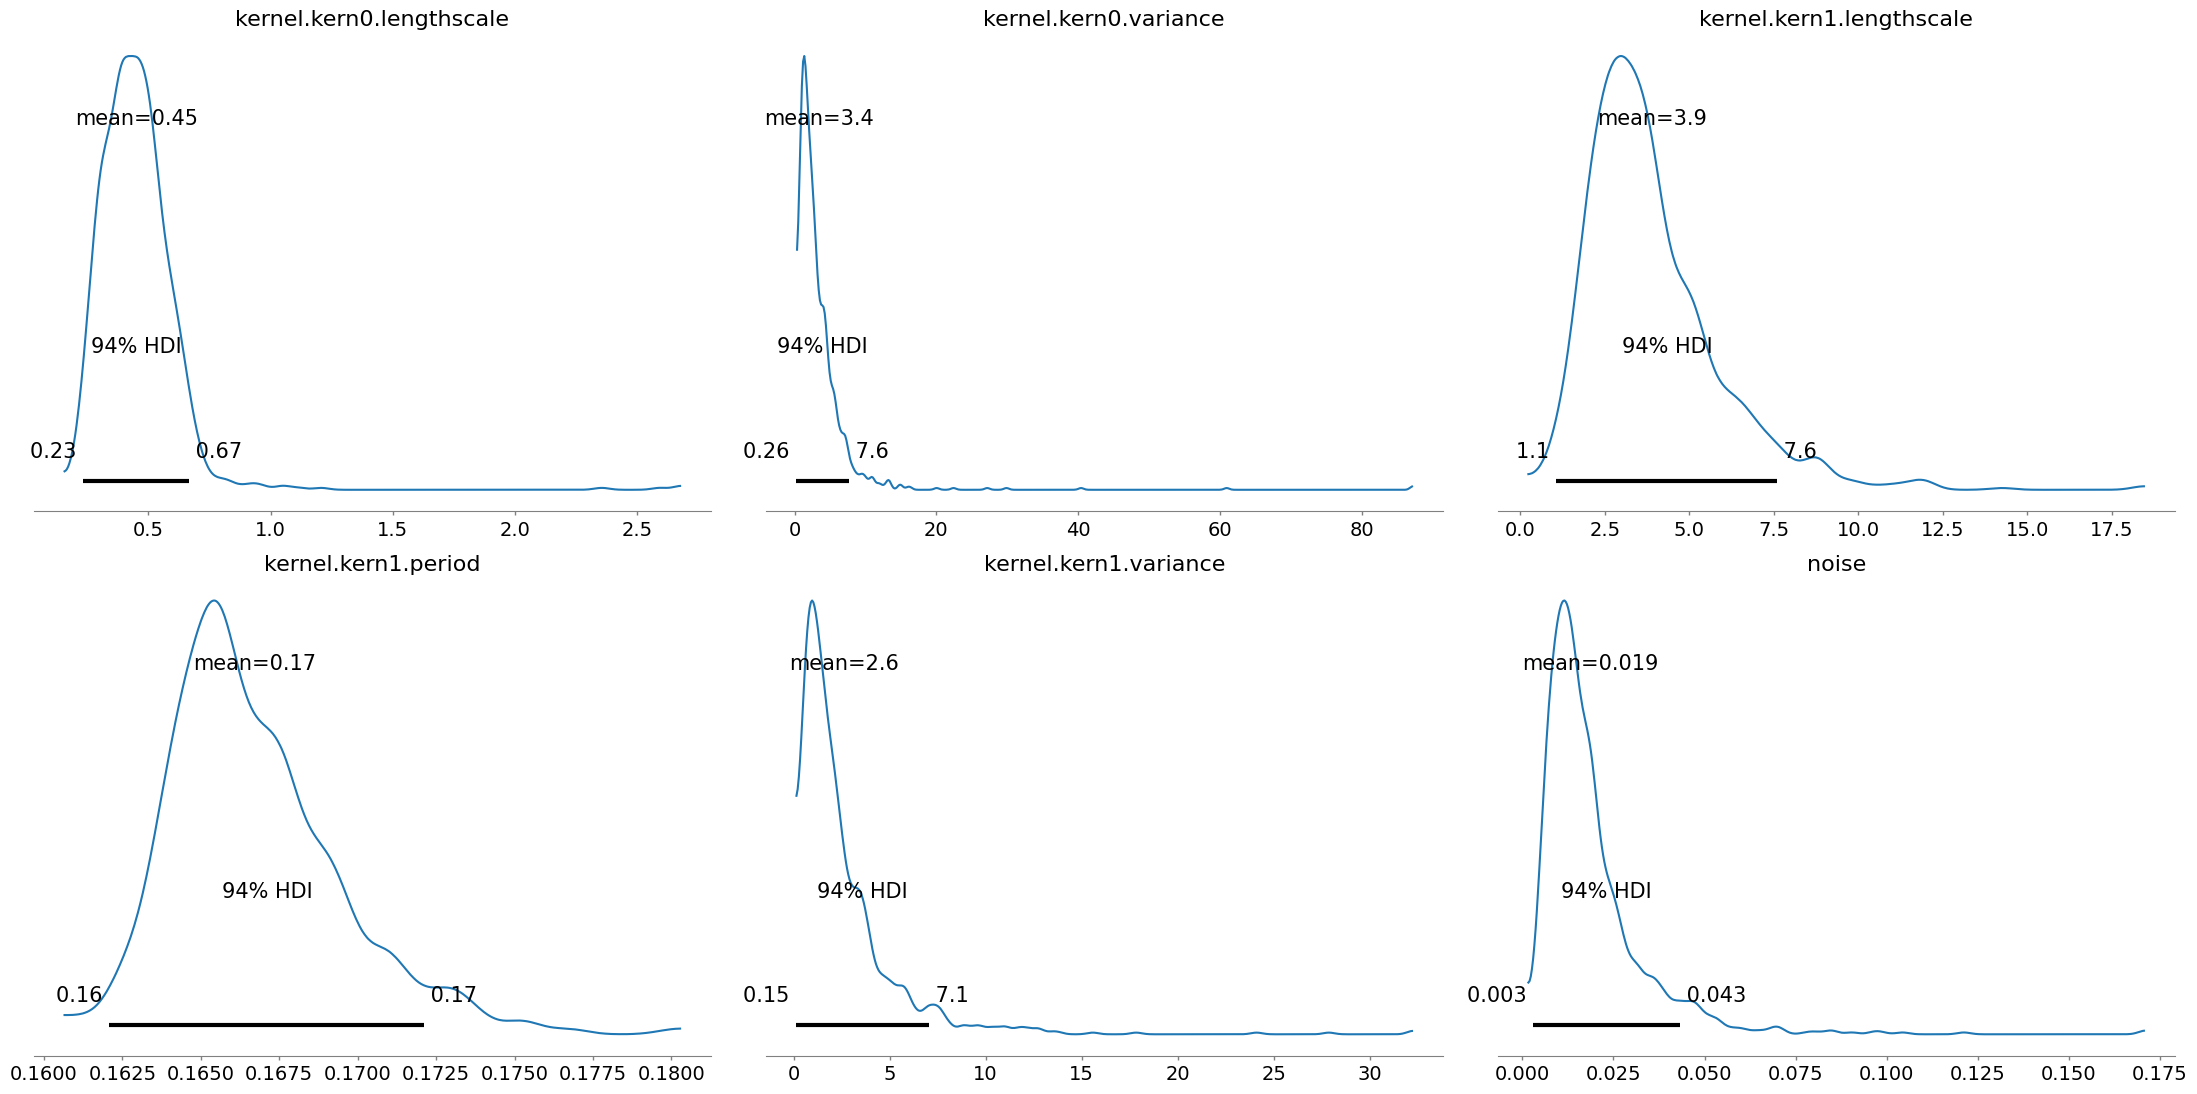

In [34]:
arviz_data = az.from_pyro(mcmc)
az.plot_trace(arviz_data);
plt.tight_layout()
plt.savefig("arviz_trace.png", dpi = 400)
az.plot_posterior(arviz_data);
plt.tight_layout()
plt.savefig("arviz_posterior.png", dpi = 400)
summ = az.summary(arviz_data)

In [35]:
import pandas as pd
summ = az.summary(arviz_data)
df = pd.DataFrame(summ)
print(df.to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &   mean &     sd &  hdi\_3\% &  hdi\_97\% &  mcse\_mean &  mcse\_sd &  ess\_bulk &  ess\_tail &  r\_hat \\
\midrule
kernel.kern0.lengthscale &  0.453 &  0.174 &   0.232 &    0.667 &      0.008 &    0.006 &     597.0 &     611.0 &    1.0 \\
kernel.kern0.variance    &  3.413 &  4.452 &   0.257 &    7.643 &      0.151 &    0.107 &     670.0 &     692.0 &    1.0 \\
kernel.kern1.lengthscale &  3.896 &  1.960 &   1.061 &    7.606 &      0.090 &    0.063 &     469.0 &     433.0 &    1.0 \\
kernel.kern1.period      &  0.167 &  0.003 &   0.162 &    0.172 &      0.000 &    0.000 &     583.0 &     431.0 &    1.0 \\
kernel.kern1.variance    &  2.609 &  2.725 &   0.151 &    7.055 &      0.108 &    0.077 &     566.0 &     582.0 &    1.0 \\
noise                    &  0.019 &  0.014 &   0.003 &    0.043 &      0.001 &    0.000 &     571.0 &     646.0 &    1.0 \\
\bottomrule
\end{tabular}



<ipython-input-35-2a7f15851e7c>:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


In [42]:

test_loglikelihoods = []
generated_data_list = []

for i in range(20):
    print("Beginning iteration", i)
    pyro.clear_param_store()
    x_train, y_train, x_test, y_test = gen_data()
    generated_data_list.append((x_train, y_train, x_test, y_test))

    # Defining our kernels and GP-model
    rbf = gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(0.9))
    periodic = gp.kernels.Periodic(input_dim=1, period=torch.tensor(0.5), lengthscale=torch.tensor(1.0), variance=torch.tensor(1.0))
    kernel = gp.kernels.Sum(kern0=rbf, kern1=periodic)
    gpr = gp.models.GPRegression(x_train, y_train, kernel=kernel, noise=torch.tensor(0.01))

    # Putting priors on our kernel parameters
    gpr.kernel.kern0.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
    gpr.kernel.kern1.period = pyro.nn.PyroSample(dist.Exponential(4.0))
    gpr.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    gpr.kernel.kern1.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
    gpr.noise = pyro.nn.PyroSample(dist.Gamma(1.0, 1.0))

    # SVI with delta distribution as guide

    nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile=True)
    mcmc=pyro.infer.MCMC(nuts_kernel, num_samples=500, num_chains=2, warmup_steps=500)
    mcmc.run()
    samples_post = mcmc.get_samples()


    test_loglikelihoods.append(approximate_log_likelihood(x_test, y_test, samples_post))

/usr/local/lib/python3.10/dist-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(


Beginning iteration 0


Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace t

Beginning iteration 1


Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace t

Beginning iteration 2


Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace t

Beginning iteration 3


Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace t

Beginning iteration 4


Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace t

Beginning iteration 5


Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace t

Beginning iteration 6


Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace t

Beginning iteration 7


Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace t

Beginning iteration 8


Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace t

Beginning iteration 9


Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace t

Beginning iteration 10


Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace t

Beginning iteration 11


Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace t

Beginning iteration 12


Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace t

Beginning iteration 13


Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace t

Beginning iteration 14


Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace t

Beginning iteration 15


Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace t

Beginning iteration 16


Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace t

Beginning iteration 17


Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace t

Beginning iteration 18


Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace t

Beginning iteration 19


Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace t

In [51]:
print(list(samples_post.values())[0].shape)
print(test_loglikelihoods)

torch.Size([1000])
[tensor(-10.5510), tensor(-9.1968), tensor(-4.9337), tensor(-5.6695), tensor(-5.9530), tensor(-7.3516), tensor(-9.0502), tensor(-6.2321), tensor(-10.6579), tensor(-7.7787), tensor(-5.7525), tensor(-5.0499), tensor(-5.0288), tensor(-15.5746), tensor(-7.1236), tensor(-8.5912), tensor(-8.1357), tensor(-6.0298), tensor(-12.8657), tensor(-8.4625)]


In [43]:
map_log_likelihood = [-10.591714859008789,
 -9.883598327636719,
 -10.453899383544922,
 -9.179474830627441,
 -9.62856674194336,
 -9.440887451171875,
 -5.739197254180908,
 -8.277508735656738,
 -9.285099029541016,
 -6.807969093322754,
 -7.776616096496582,
 -8.214893341064453,
 -11.072059631347656,
 -10.004533767700195,
 -8.960026741027832,
 -11.985212326049805,
 -8.077812194824219,
 -10.363739967346191,
 -10.677692413330078,
 -7.064223766326904]

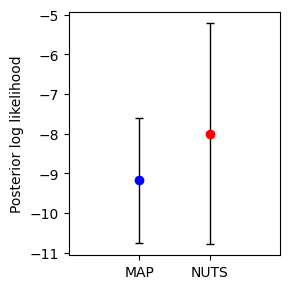

MAP: -9.174236297607422 1.5742086892569525
NUTS: -7.9994416 2.7870896


In [63]:
# mcmc_log_likelihood = [tensor.to_numpy() for tensor in test_loglikelihoods]
fig, ax = plt.subplots(figsize = (3,3))
ax.errorbar(1, np.mean(map_log_likelihood), yerr = np.std(map_log_likelihood, ddof = 1), ecolor = "k", capsize = 3, elinewidth = 1, color = "b", fmt = "o")
ax.errorbar(2, np.mean(test_loglikelihoods), yerr = np.std(test_loglikelihoods, ddof = 1), ecolor = "k", capsize = 3, elinewidth = 1, color = "r", fmt = "o")
ax.set_xticks([1,2], ["MAP", "NUTS"])
ax.set_xlim(0,3)
ax.set(ylabel = "Posterior log likelihood")
plt.tight_layout()
plt.savefig("B1_loglikelihood_comp.png", dpi = 400)
plt.show()
print("MAP:", np.mean(map_log_likelihood), np.std(map_log_likelihood, ddof = 1))
print("NUTS:", np.mean(test_loglikelihoods), np.std(test_loglikelihoods, ddof = 1))